In [1]:
import os
import math
import sys
import warnings
import json
from pathlib import Path

import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageColor
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2

from torchvision.models.detection.anchor_utils import AnchorGenerator
import torchvision
import torch
from torchvision import transforms as T
from torchmetrics.detection.map import MeanAveragePrecision
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn, FastRCNNPredictor, FasterRCNN

from torch.utils.tensorboard import SummaryWriter

warnings.filterwarnings("ignore")

In [2]:
import dotenv
dotenv.load_dotenv(override=True)

DATA = os.getenv("DATA")
MTSD = os.getenv("MTSD")
if not DATA:
    raise Exception('Not able to find "DATA" environment variable')
if not MTSD:
    raise Exception('Not able to find "MTSD" environment variable')

classes_dir = os.path.join(DATA, 'classes')
img_dir = os.path.join(MTSD, 'images')
anno_train = os.path.join(MTSD, 'anno_train')
anno_val = os.path.join(MTSD, 'anno_val')
anno_test = os.path.join(MTSD, 'anno_test')
print(classes_dir)
print(img_dir)
print(anno_train)
print(anno_val)
print(anno_test)

C:\Users\saibo\Documents\bachelor_project\data\classes
C:\Users\saibo\Documents\bachelor_project\data\MTSD\images
C:\Users\saibo\Documents\bachelor_project\data\MTSD\anno_train
C:\Users\saibo\Documents\bachelor_project\data\MTSD\anno_val
C:\Users\saibo\Documents\bachelor_project\data\MTSD\anno_test


In [3]:
with open(os.path.join(classes_dir, 'map_str2num.json')) as f:
    str2num = json.load(f)
num_classes = len(str2num)
num_classes

53

In [4]:
class MTSD_Dataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, anno_dir, extension='jpg', transforms=None, only_detect=False, threshold=900, keep_other=False):
        self.image_dir = image_dir
        self.anno_dir = anno_dir
        self.extension = extension
        self.transforms = transforms
        self.only_detect = only_detect
        self.threshold = threshold
        self.keep_other = keep_other
        self.ids = sorted([Path(anno).stem for anno in os.listdir(anno_dir)])

    def get_no_transform(self, idx):
        img_path = os.path.join(self.image_dir, f"{self.ids[idx]}.{self.extension}")
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255
        

        anno_path = os.path.join(self.anno_dir, f"{self.ids[idx]}.json")
        with open(anno_path) as f:
            anno = json.load(f)

        target = {"labels": [], "labels_str": [], "boxes": [], "areas": []}

        for label, label_str, box, area in zip(anno["labels"], anno["labels_str"], anno["boxes"], anno["areas"]):
            if area >= self.threshold and (label_str != "other-sign" or self.keep_other):
                target["labels"].append(label)
                target["labels_str"].append(label_str)
                target["boxes"].append(box)
                target["areas"].append(area)

        return img, target

    def __getitem__(self, idx):
        img, _target = self.get_no_transform(idx)

        target = {}

        target["boxes"] = torch.as_tensor(_target['boxes'], dtype=torch.float32)

        target["labels"] = (
            torch.as_tensor(_target["labels"], dtype=torch.int64)
            if not self.only_detect
            else torch.ones(len(_target["labels"]), dtype=torch.int64)
        )

        local_transforms = self.transforms(height=img.shape[0], width=img.shape[1])

        if self.transforms is not None:
            sample = local_transforms(image=img, bboxes=target["boxes"], labels=target["labels"])

            max_tries = 100
            while len(sample["bboxes"]) == 0:
                sample = local_transforms(image=img, bboxes=target["boxes"], labels=target["labels"])

                max_tries -= 1
                if max_tries <= 0:
                    break

            img = sample["image"]
            target["boxes"] = torch.as_tensor(sample["bboxes"], dtype=torch.float32)
            target["labels"] = torch.as_tensor(sample["labels"], dtype=torch.int64)
        else:
            img = ToTensorV2()(img)
        
        if len(target["boxes"]) == 0:
            target["boxes"] = torch.empty((0,4), dtype=torch.float32)
            target["labels"] = torch.empty((0), dtype=torch.int64)
 
        return img, target
 
    def __len__(self):
        return len(self.ids)

def collate_fn(batch):
    return tuple(zip(*batch))

In [5]:
def get_transform(train):
    if train:
        return transform_train
    else:
        return transoform_test

def transform_train(width=1000, height=1000):
    if width > 1000:
        width = 1000
    if height > 1000:
        height = 1000

    return A.Compose(
        [
            A.RandomSizedBBoxSafeCrop(width=1000, height=1000, p=1.0),
            A.RandomBrightnessContrast(p=0.5),
            A.Rotate(limit=(-20, 20), p=0.5),
            A.GaussianBlur(blur_limit=(3, 5), sigma_limit=(0.1, 0.2), p=0.5),
            ToTensorV2(p=1.0),
        ],
        bbox_params={
            "format": "pascal_voc",
            "label_fields": ["labels"],
            "min_area": 900,
        },
    )

def transoform_test(width=1000, height=1000):
    if width >= 2024 or height >= 2024:
        if width >= height:
            if width > 4000:
                height = height * 4000 // width
                width = 4000
            else:
                height = height * 2024 // width
                width = 2024
        else:
            if height > 4000:
                width = width * 4000 // height
                height = 4000
            else:
                width = width * 2040 // height
                height = 2040

    return A.Compose(
        [
            A.Resize(width=width, height=height, p=1.0),
            ToTensorV2(p=1.0),
        ],
        bbox_params={"format": "pascal_voc", "label_fields": ["labels"]},
    )

In [8]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, scaler=None, writer=None):
    model.train()

    total_loss = []

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for idx, (images, targets) in enumerate(
        tqdm(data_loader, desc=f"Epoch [{epoch+1}]", position=0, leave=True)
    ):
        # to device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # loss
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        total_loss += [losses.item()]

    if writer is not None:
        writer.add_scalar("Loss/train", np.mean(total_loss), epoch)

    return np.mean(total_loss)

@torch.inference_mode()
def evaluate(model, data_loader, device, metric, epoch, writer=None):
    model.eval()

    for images, targets in tqdm(data_loader, desc="Evaluating score", position=0, leave=True):
        # to device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.cuda.amp.autocast(enabled=False):
            detections = model(images, targets)

        metric.update(detections, targets)

    scores = metric.compute()
    metric.reset()


    model.train() # to get loss

    total_loss = []

    for images, targets in tqdm(data_loader, desc="Evaluating loss", position=0, leave=True):
        # to device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        total_loss += [losses.item()]

    if writer is not None:
        writer.add_scalar("Loss/val", np.mean(total_loss), epoch)
        writer.add_scalars("Score/val", scores, epoch)

    return np.mean(total_loss), scores


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [7]:
only_detect = True
num_classes = 2 if only_detect else num_classes

dataset_train = MTSD_Dataset(img_dir, anno_train, transforms=get_transform(True), only_detect=only_detect)
dataset_val = MTSD_Dataset(img_dir, anno_val, transforms=get_transform(False), only_detect=only_detect)


data_loader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn,
)
data_loader_val = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn,
    )

In [17]:
# anchor_sizes = ((32,), (64,), (128,), (256,))
# aspect_ratios = ((1,),) * len(anchor_sizes)
# rpn_anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)

# backbone = torchvision.models.detection.backbone_utils.resnet_fpn_backbone('resnet50', True)
# backbone.out_channels = 256

# roi_pooler = torchvision.ops.MultiScaleRoIAlign(
#     featmap_names=[0],
#     output_size=7,
#     sampling_ratio=2)
# model = FasterRCNN(
#     backbone, 
#     num_classes=num_classes,
#     rpn_anchor_generator=rpn_anchor_generator,
#     box_roi_pool=roi_pooler
# )

model = fasterrcnn_resnet50_fpn(
    pretrained=False, num_classes=num_classes, pretrained_backbone=True
)

# model = torch.load('./train150.pkl')


# model = fasterrcnn_resnet50_fpn(pretrained=True)
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [18]:
num_epochs = 15

val_metric = MeanAveragePrecision()

train_losses = []
val_losses = []
val_scores = []

writer = SummaryWriter(log_dir="logs/mtsd/run_3")

model = model.to(device)

for epoch in range(num_epochs):
    # train one epoch
    loss = train_one_epoch(model, optimizer, data_loader_train, device=device, epoch=epoch, writer=writer)
    train_losses += [loss]

    # update the learning rate
    lr_scheduler.step()

    # evaluate on the test dataset
    loss, scores = evaluate(model, data_loader_val, device=device, metric=val_metric, epoch=epoch, writer=writer)
    val_losses += [loss]
    val_scores += [scores]

writer.flush()

Epoch [1]:  12%|█▏        | 323/2693 [03:07<22:54,  1.72it/s]


KeyboardInterrupt: 

In [115]:
torch.save(model, f'./saved_models/mtsd/model{num_epochs}.pkl')
torch.save(model.state_dict(), f'./saved_models/mtsd/model{num_epochs}.pth')
torch.save({
    'epoch' : epoch,
    "model_state_dict" : model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),
}, f'./saved_models/mtsd/ckpt{num_epochs}.pth')

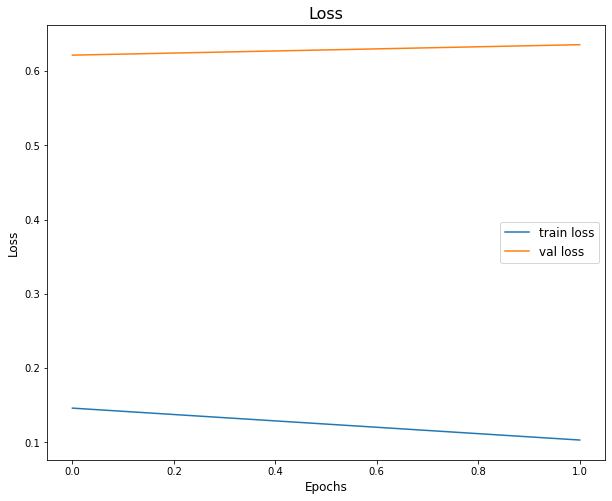

In [125]:
epochs = range(num_epochs)
fig = plt.figure(figsize=(10,8))
plt.plot(epochs, train_losses, label="train loss")
plt.plot(epochs, val_losses, label="val loss")
plt.xlabel("Epochs", fontdict={'size': 12})
plt.ylabel("Loss", fontdict={'size': 12})
plt.title("Loss", fontdict={'size': 16})
plt.legend(prop={'size': 12})
plt.show()

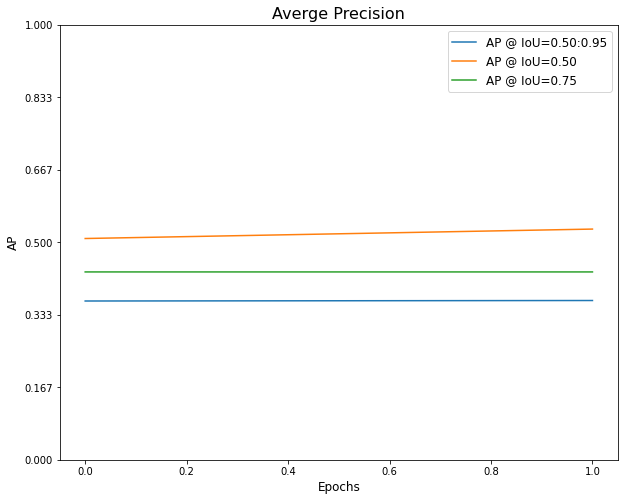

In [122]:
val_map = [elm['map'] for elm in val_scores]
val_map50 = [elm['map_50'] for elm in val_scores]
val_map75 = [elm['map_75'] for elm in val_scores]

score_metric = "AP" if only_detect else "mAP"

fig = plt.figure(figsize=(10,8))
plt.plot(epochs, val_map, label=f"{score_metric} @ IoU=0.50:0.95")
plt.plot(epochs, val_map50, label=f"{score_metric} @ IoU=0.50")
plt.plot(epochs, val_map75, label=f"{score_metric} @ IoU=0.75")
plt.xlabel("Epochs", fontdict={'size': 12})
plt.ylabel(score_metric, fontdict={'size': 12})
plt.yticks(np.linspace(0, 1, 7))
plt.title("Averge Precision", fontdict={'size': 16})
plt.legend(prop={'size': 12})
plt.show()

In [123]:
final_score = val_scores[-1]
final_score

{'map': tensor(0.3663),
 'map_50': tensor(0.5305),
 'map_75': tensor(0.4320),
 'map_small': tensor(0.0645),
 'map_medium': tensor(0.3666),
 'map_large': tensor(0.6423),
 'mar_1': tensor(0.2953),
 'mar_10': tensor(0.4807),
 'mar_100': tensor(0.4811),
 'mar_small': tensor(0.1133),
 'mar_medium': tensor(0.5050),
 'mar_large': tensor(0.8005),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}

In [126]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color, font, thickness=4, display_str=""):
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_height = (1 + 2 * 0.05) * font.getsize(display_str)[1]

  if top > display_str_height:
    text_bottom = top
  else:
    text_bottom = top + display_str_height

  text_width, text_height = font.getsize(display_str)
  margin = np.ceil(0.05 * text_height)
  draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)
  draw.text((left + margin, text_bottom - text_height - margin), display_str, fill="black", font=font)



def draw_boxes(image, boxes, labels, scores, keep, max_boxes=10, min_score=0.01, classes=None):
  """ returns PIL image with boxes """
  colors = list(ImageColor.colormap.values())
  font = ImageFont.load_default()

  im_height, im_width = image.shape[1:]
  image_pil = T.ToPILImage()(image)

  for i in range(min(len(boxes), max_boxes)):
    if scores[i] >= min_score and i in keep:
      xmin, ymin, xmax, ymax = tuple(boxes[i])
      xmin, ymin, xmax, ymax = xmin / im_width, ymin / im_height, xmax / im_width, ymax / im_height
      label = classes[labels[i].item()] if classes is not None else labels[i].item()
      display_str = f"{label}: {int(100 * scores[i])}%"
      color = colors[hash(labels[i]) % len(colors)]
      draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color, font, display_str=display_str)
  return image_pil

In [14]:
with open(os.path.join(classes_dir, "map_str2num.json")) as f:
    str2num = json.load(f)
num2str = {v:k for v,k in str2num.items()} if not only_detect else {1: "sign"}
len(num2str)

1

In [15]:
def predict(img, model):
    model.eval()

    with torch.no_grad():
        pred = model([img.to(device)])[0]

    keep = torchvision.ops.nms(pred['boxes'] , pred['scores'], 0.1)
    return pred, keep

def predict_and_display(img, model):
    pred, keep = predict(img, model)
    labels = [num2str[label] for label in pred['labels'].cpu()]
    return draw_boxes(img.cpu(), pred['boxes'].cpu(), labels, pred['scores'].cpu(), keep.cpu())

In [16]:
i = 92
predict_and_display(dataset_val[i][0], model)

NameError: name 'model' is not defined